<div style="text-align: right;">© 2025 Moses Boudourides. All Rights Reserved.</div>

# Word Embeddings for Hypergraph Reconstruction 

This notebook applies **Word Embeddings** for hyperedge prediction in a hypergraph. 

## Input Format
- **Hypergraph**: Dictionary with hyperedge keys and node sets as values
- Nodes can be integers or strings

## Output
- **ML Scores**: F1, Recall, Precision, Accuracy, ROC-AUC, Log Loss, Matthews Coefficient
- **Structural Evaluation Metrics**: These metrics measure how well the Word Embeddings algorithm groups nodes with strong connectivity patterns together in predicted hyperedges, comparing the internal connectivity of predictions against random baselines and analyzing whether the algorithm preferentially selects high-degree nodes.
- **ROC-AUC Curves** for all examples
- **Comprehensive Comparison Table** with all metrics

## Examples
- **Southern Women Bipartite Graph (Hypergraph)**
- **Karate Club Clique Hypergraph**
- **Les Miserables Clique Hypergraph**
- **Random Hypergraph**

In [1]:
import numpy as np
import scipy.sparse as sp
from sklearn import metrics
from sklearn.metrics import accuracy_score, log_loss, matthews_corrcoef
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
import random
import warnings
import itertools
import collections
import matplotlib.pyplot as plt
import pandas as pd
import json
import os
from datetime import datetime
from pathlib import Path
warnings.filterwarnings('ignore')

# Set matplotlib style
plt.style.use('default')
plt.rcParams['figure.figsize'] = (10, 6)

## Random Hypergraph Generator

In [2]:
def hypergraph_random_creator(vertices, hyperedge_names, m, minv, maxv, weighted=False, weight_range=(1, 10)):
    """
    Creates a random hypergraph with custom vertex and hyperedge names.

    Parameters:
    - vertices (list of int or str): List of vertex names.
    - hyperedge_names (list of str): List of hyperedge names.
    - m (int): Number of hyperedges to create (must be <= length of hyperedge_names).
    - minv (int): Minimum number of nodes in a hyperedge.
    - maxv (int): Maximum number of nodes in a hyperedge (must be > minv).
    - weighted (bool): If True, creates a weighted hypergraph where nodes have weights.
    - weight_range (tuple): Range of weights (min, max) to assign to nodes if weighted=True.

    Returns:
    - hg_d (dict): A dictionary representing the hypergraph, with keys as hyperedge names and values as sets of nodes.
                   If weighted=True, values are dictionaries mapping nodes to their weights.
    """
    # Check if m is valid
    if m > len(hyperedge_names):
        raise ValueError("m cannot be greater than the number of hyperedge names provided.")
    
    if minv > maxv:
        raise ValueError("minv must be less than or equal to maxv.")
    
    if minv < 1:
        raise ValueError("minv must be at least 1.")
    
    if maxv > len(vertices):
        raise ValueError("maxv cannot be greater than the number of vertices.")
    
    hg_d = {}
    for k in range(m):
        # Random number of nodes for this hyperedge
        r = random.randint(minv, maxv)
        
        # Sample nodes without replacement
        nodes = random.sample(vertices, r)
        
        # Sort nodes for consistency
        sorted_nodes = sorted(nodes)

        # If weighted, create a dictionary mapping nodes to weights
        if weighted:
            sorted_nodes = {node: random.randint(weight_range[0], weight_range[1]) for node in sorted_nodes}
        else:
            # Convert to set for unweighted hypergraphs
            sorted_nodes = set(sorted_nodes)
        
        hg_d[hyperedge_names[k]] = sorted_nodes
        
    return hg_d

## Hypergraph Utilities

In [3]:
def hypergraph_dict_to_incidence_matrix(hypergraph_dict):
    """
    Convert dictionary-based hypergraph to incidence matrix
    """
    # Get all unique nodes
    all_nodes = set()
    for nodes in hypergraph_dict.values():
        if isinstance(nodes, dict):
            all_nodes.update(nodes.keys())
        else:
            all_nodes.update(nodes)
    
    # Create mappings
    node_to_idx = {node: idx for idx, node in enumerate(sorted(list(all_nodes)))}
    idx_to_node = {idx: node for node, idx in node_to_idx.items()}
    
    hyperedge_keys = list(hypergraph_dict.keys())
    hyperedge_to_idx = {he: idx for idx, he in enumerate(hyperedge_keys)}
    idx_to_hyperedge = {idx: he for he, idx in hyperedge_to_idx.items()}
    
    # Create incidence matrix
    n_nodes = len(all_nodes)
    n_hyperedges = len(hypergraph_dict)
    
    H = sp.lil_matrix((n_nodes, n_hyperedges), dtype=float)
    
    for he_idx, (he_key, nodes) in enumerate(hypergraph_dict.items()):
        if isinstance(nodes, dict):
            for node, weight in nodes.items():
                node_idx = node_to_idx[node]
                H[node_idx, he_idx] = weight
        else:
            for node in nodes:
                node_idx = node_to_idx[node]
                H[node_idx, he_idx] = 1.0
    
    return H.tocsr(), node_to_idx, idx_to_node, hyperedge_to_idx, idx_to_hyperedge

def learn_node_embeddings(H, embedding_dim=64, random_state=42):
    """
    Learn node embeddings from hypergraph incidence matrix using SVD
    """
    # Use TruncatedSVD to learn embeddings from the incidence matrix
    svd = TruncatedSVD(n_components=min(embedding_dim, min(H.shape) - 1), random_state=random_state)
    
    # Fit SVD on the incidence matrix
    node_embeddings = svd.fit_transform(H)
    
    # Normalize embeddings
    node_embeddings = normalize(node_embeddings, norm='l2')
    
    return node_embeddings

def get_embedding_similarity_matrix(node_embeddings):
    """
    Compute pairwise cosine similarity matrix from node embeddings
    """
    similarity_matrix = cosine_similarity(node_embeddings)
    
    # Remove self-similarities (set diagonal to 0)
    np.fill_diagonal(similarity_matrix, 0)
    
    return similarity_matrix

## Word Embeddings Algorithm Implementation

In [4]:
def get_pref_node(H, node_embeddings):
    """
    Get a node based on embedding magnitude (high-dimensional representation strength)
    """
    # Compute embedding magnitudes (L2 norms)
    embedding_magnitudes = np.linalg.norm(node_embeddings, axis=1)
    
    # Add small epsilon to avoid zero probabilities
    embedding_magnitudes = embedding_magnitudes + 1e-8
    
    # Normalize to get probabilities
    probabilities = embedding_magnitudes / np.sum(embedding_magnitudes)
    
    # Sample node based on embedding magnitude
    node_id = np.random.choice(len(probabilities), p=probabilities)
    
    return node_id

def compute_NHAS(hyperedge_nodes, embedding_scores, candidate_nodes):
    """
    Compute Node-Hyperedge Attachment Scores (NHAS) for candidate nodes
    """
    scores = []
    valid_candidates = []
    
    for candidate_node in candidate_nodes:
        if candidate_node not in hyperedge_nodes:
            score = 0
            for node in hyperedge_nodes:
                score += embedding_scores[node, candidate_node]
            scores.append(max(0, score))  # Ensure non-negative scores
            valid_candidates.append(candidate_node)
    
    return valid_candidates, scores

def predict_hyperedge(H, embedding_scores, edge_degree, node_to_idx, idx_to_node, node_embeddings):
    """
    Predict a new hyperedge using Word Embeddings algorithm
    """
    hyperedge_indices = set()
    
    # Get initial node based on embedding magnitude
    initial_node_idx = get_pref_node(H, node_embeddings)
    hyperedge_indices.add(initial_node_idx)
    
    nodes_count = H.shape[0]
    max_iterations = edge_degree * 2  # Prevent infinite loops
    iterations = 0
    
    while len(hyperedge_indices) < edge_degree and iterations < max_iterations:
        candidate_nodes = list(range(nodes_count))
        valid_candidates, scores = compute_NHAS(hyperedge_indices, embedding_scores, candidate_nodes)
        
        if not valid_candidates or np.sum(scores) == 0:
            # If no valid candidates or all scores are zero, select randomly
            remaining_nodes = [i for i in range(nodes_count) if i not in hyperedge_indices]
            if remaining_nodes:
                selected_node = np.random.choice(remaining_nodes)
                hyperedge_indices.add(selected_node)
            else:
                break
        else:
            # Select node based on NHAS scores
            probabilities = np.array(scores) / np.sum(scores)
            selected_node = np.random.choice(valid_candidates, p=probabilities)
            hyperedge_indices.add(selected_node)
        
        iterations += 1
    
    # Convert back to original node identifiers
    predicted_hyperedge = {idx_to_node[idx] for idx in hyperedge_indices}
    
    return predicted_hyperedge

## Evaluation Metrics

In [5]:
# Traditional ML Metrics
def compute_auc(y_true, y_scores):
    """Compute ROC-AUC score"""
    try:
        if len(set(y_true)) < 2:
            return 0.5  # Only one class present
        fpr, tpr, thresholds = metrics.roc_curve(y_true, y_scores)
        auc = metrics.auc(fpr, tpr)
        return auc
    except:
        return 0.5  # Random classifier baseline

def compute_precision(y_true, y_pred):
    """Compute precision score"""
    return metrics.precision_score(y_true, y_pred, average='binary', zero_division=0)

def compute_recall(y_true, y_pred):
    """Compute recall score"""
    return metrics.recall_score(y_true, y_pred, average='binary', zero_division=0)

def compute_f1_score(y_true, y_pred):
    """Compute F1 score"""
    return metrics.f1_score(y_true, y_pred, average='binary', zero_division=0)

def compute_accuracy(y_true, y_pred):
    """Compute accuracy score"""
    return accuracy_score(y_true, y_pred)

def compute_log_loss(y_true, y_proba):
    """Compute log loss"""
    try:
        # Ensure probabilities are in valid range [eps, 1-eps]
        eps = 1e-15
        y_proba = np.clip(y_proba, eps, 1 - eps)
        return log_loss(y_true, y_proba)
    except:
        return float('inf')

def compute_matthews_corrcoef(y_true, y_pred):
    """Compute Matthews correlation coefficient"""
    try:
        return matthews_corrcoef(y_true, y_pred)
    except:
        return 0.0  # No correlation baseline

def compute_all_ml_scores(y_true, y_pred, y_scores=None):
    """Compute all 7 ML scores"""
    scores = {}
    
    # Binary classification metrics
    scores['precision'] = compute_precision(y_true, y_pred)
    scores['recall'] = compute_recall(y_true, y_pred)
    scores['f1'] = compute_f1_score(y_true, y_pred)
    scores['accuracy'] = compute_accuracy(y_true, y_pred)
    scores['matthews_corrcoef'] = compute_matthews_corrcoef(y_true, y_pred)
    
    # Metrics requiring probability scores
    if y_scores is not None:
        scores['roc_auc'] = compute_auc(y_true, y_scores)
        # Convert scores to probabilities for log loss
        y_proba = 1 / (1 + np.exp(-np.array(y_scores)))  # Sigmoid transformation
        scores['log_loss'] = compute_log_loss(y_true, y_proba)
    else:
        scores['roc_auc'] = 0.5
        scores['log_loss'] = float('inf')
    
    return scores

# Structural Metrics
def calculate_internal_connectivity(hyperedge, embedding_scores, node_to_idx):
    """Calculate the average pairwise embedding similarity within a hyperedge."""
    node_indices = [node_to_idx[node] for node in hyperedge if node in node_to_idx]
    if len(node_indices) < 2:
        return 0.0
    
    total_score = 0
    num_pairs = 0
    for i, node1_idx in enumerate(node_indices):
        for node2_idx in node_indices[i+1:]:
            total_score += embedding_scores[node1_idx, node2_idx]
            num_pairs += 1
            
    return total_score / num_pairs if num_pairs > 0 else 0.0

def calculate_random_baseline_connectivity(embedding_scores, node_to_idx, size, num_samples=100):
    """Calculate the average internal connectivity for random hyperedges of a given size."""
    if size < 2 or size > len(node_to_idx):
        return 0.0
        
    all_node_indices = list(node_to_idx.values())
    total_random_score = 0
    valid_samples = 0
    
    for _ in range(num_samples):
        random_indices = random.sample(all_node_indices, size)
        if len(random_indices) < 2:
            continue
            
        current_score = 0
        num_pairs = 0
        for i, node1_idx in enumerate(random_indices):
            for node2_idx in random_indices[i+1:]:
                current_score += embedding_scores[node1_idx, node2_idx]
                num_pairs += 1
        
        if num_pairs > 0:
            total_random_score += current_score / num_pairs
            valid_samples += 1
            
    return total_random_score / valid_samples if valid_samples > 0 else 0.0

def analyze_node_degrees(hyperedges, H, node_to_idx):
    """Analyze the degree distribution of nodes in given hyperedges compared to overall."""
    all_node_degrees = np.squeeze(np.asarray(H.sum(axis=1)))
    avg_overall_degree = np.mean(all_node_degrees)
    
    degrees_in_hyperedges = []
    for he in hyperedges:
        for node in he:
            if node in node_to_idx:
                degrees_in_hyperedges.append(all_node_degrees[node_to_idx[node]])
                
    avg_degree_in_hyperedges = np.mean(degrees_in_hyperedges) if degrees_in_hyperedges else 0.0
    
    return avg_overall_degree, avg_degree_in_hyperedges

def analyze_hyperedge_sizes(original_hyperedges, predicted_hyperedges):
    """Compare the size distribution of original and predicted hyperedges."""
    original_sizes = [len(he) for he in original_hyperedges]
    predicted_sizes = [len(he) for he in predicted_hyperedges]
    
    avg_original_size = np.mean(original_sizes) if original_sizes else 0.0
    avg_predicted_size = np.mean(predicted_sizes) if predicted_sizes else 0.0
    
    return avg_original_size, avg_predicted_size, collections.Counter(original_sizes), collections.Counter(predicted_sizes)

def generate_classification_data(predicted_hyperedges, original_hyperedges_nodes, embedding_scores, node_to_idx, num_negative_samples=None):
    """Generate classification data for ML evaluation with balanced classes."""
    # Create set of original hyperedges
    original_hyperedges_set = set()
    for nodes in original_hyperedges_nodes:
        original_hyperedges_set.add(frozenset(nodes))
    
    y_true = []
    y_scores = []
    
    # Positive examples: predicted hyperedges that exist in original
    positive_count = 0
    for pred_he in predicted_hyperedges:
        exists = frozenset(pred_he) in original_hyperedges_set
        y_true.append(1 if exists else 0)
        if exists:
            positive_count += 1
        
        # Compute score based on embedding similarity values
        score = calculate_internal_connectivity(pred_he, embedding_scores, node_to_idx)
        y_scores.append(score)
    
    # If we have very few positives, generate some negative examples for balance
    if positive_count < len(predicted_hyperedges) * 0.1:  # Less than 10% positive
        if num_negative_samples is None:
            num_negative_samples = min(len(predicted_hyperedges), 50)
        
        # Generate random hyperedges as negative examples
        all_nodes = list(node_to_idx.keys())
        predicted_sizes = [len(he) for he in predicted_hyperedges]
        
        for _ in range(num_negative_samples):
            size = np.random.choice(predicted_sizes) if predicted_sizes else 3
            if size <= len(all_nodes):
                random_he = set(random.sample(all_nodes, size))
                exists = frozenset(random_he) in original_hyperedges_set
                y_true.append(1 if exists else 0)
                
                score = calculate_internal_connectivity(random_he, embedding_scores, node_to_idx)
                y_scores.append(score)
    
    return y_true, y_scores

def plot_roc_curve(y_true, y_scores, title="ROC Curve"):
    """Plot ROC curve and return AUC score."""
    try:
        if len(set(y_true)) < 2:
            print(f"ROC curve not generated for {title}: Only one class present")
            return 0.5
            
        fpr, tpr, thresholds = metrics.roc_curve(y_true, y_scores)
        auc_score = metrics.auc(fpr, tpr)
        
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.3f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random classifier')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(title)
        plt.legend(loc="lower right")
        plt.grid(True, alpha=0.3)
        plt.show()
        
        return auc_score
    except Exception as e:
        print(f"Could not generate ROC curve for {title}: {e}")
        return 0.5

## Main Word Embeddings Analysis Function

In [6]:
def full_hypergraph_analysis_complete(hypergraph_dict, num_predictions=100, random_seed=42, plot_roc=True, embedding_dim=64):
    """
    Perform complete hypergraph analysis using Word Embeddings algorithm with all metrics.
    
    Args:
        hypergraph_dict: Dictionary with hyperedge keys and node sets as values
        num_predictions: Number of hyperedges to predict for evaluation
        random_seed: Random seed for reproducibility
        plot_roc: Whether to plot ROC curve
        embedding_dim: Dimension of node embeddings
        
    Returns:
        results: Dictionary containing all analysis results and scores
    """
    np.random.seed(random_seed)
    random.seed(random_seed)
    
    print("Starting Word Embeddings Analysis...")
    print(f"Input hypergraph: {len(hypergraph_dict)} hyperedges")
    
    # Convert to incidence matrix
    H, node_to_idx, idx_to_node, hyperedge_to_idx, idx_to_hyperedge = hypergraph_dict_to_incidence_matrix(hypergraph_dict)
    print(f"Incidence matrix shape: {H.shape} (nodes x hyperedges)")
    
    # Learn node embeddings
    node_embeddings = learn_node_embeddings(H, embedding_dim=embedding_dim, random_state=random_seed)
    print(f"Learned {embedding_dim}-dimensional node embeddings")
    
    # Compute embedding similarity matrix
    embedding_scores = get_embedding_similarity_matrix(node_embeddings)
    print("Computed embedding similarity matrix")
    
    # Get original hyperedge sizes and nodes
    original_hyperedges_nodes = []
    hyperedge_sizes = []
    for nodes in hypergraph_dict.values():
        if isinstance(nodes, dict):
            current_nodes = set(nodes.keys())
            hyperedge_sizes.append(len(current_nodes))
            original_hyperedges_nodes.append(current_nodes)
        else:
            hyperedge_sizes.append(len(nodes))
            original_hyperedges_nodes.append(set(nodes))
            
    avg_hyperedge_size = np.mean(hyperedge_sizes) if hyperedge_sizes else 0.0
    print(f"Average original hyperedge size: {avg_hyperedge_size:.2f}")
    
    # Generate predictions
    print(f"Generating {num_predictions} hyperedge predictions...")
    predicted_hyperedges = []
    
    for i in range(num_predictions):
        target_size = np.random.choice(hyperedge_sizes) if hyperedge_sizes else 3
        predicted_he = predict_hyperedge(H, embedding_scores, target_size, node_to_idx, idx_to_node, node_embeddings)
        predicted_hyperedges.append(predicted_he)
        
        if (i + 1) % (max(1, num_predictions // 5)) == 0:
             print(f"Generated {i + 1}/{num_predictions} predictions")
    
    # Generate classification data for ML evaluation
    print("Generating classification data for ML evaluation...")
    y_true, y_scores = generate_classification_data(predicted_hyperedges, original_hyperedges_nodes, embedding_scores, node_to_idx)
    
    # Convert scores to binary predictions
    threshold = np.median(y_scores) if y_scores else 0.0
    y_pred = (np.array(y_scores) >= threshold).astype(int)
    
    # Compute all 7 ML scores
    ml_scores = compute_all_ml_scores(y_true, y_pred, y_scores)
    
    # Plot ROC curve if requested
    if plot_roc:
        hypergraph_name = f"Hypergraph ({len(hypergraph_dict)} hyperedges, {len(node_to_idx)} nodes)"
        roc_auc = plot_roc_curve(y_true, y_scores, f"ROC Curve - {hypergraph_name}")
        ml_scores['roc_auc'] = roc_auc  # Update with plotted AUC
    
    # Structural evaluation
    print("Evaluating structural properties...")
    
    # 1. Internal Connectivity
    predicted_connectivities = [calculate_internal_connectivity(he, embedding_scores, node_to_idx) for he in predicted_hyperedges]
    avg_predicted_connectivity = np.mean(predicted_connectivities)
    
    # 2. Random Baseline Connectivity
    predicted_sizes = [len(he) for he in predicted_hyperedges]
    avg_random_connectivity = np.mean([calculate_random_baseline_connectivity(embedding_scores, node_to_idx, size) for size in predicted_sizes if size > 1])
    
    # 3. Node Degree Analysis
    avg_overall_degree, avg_degree_in_predicted = analyze_node_degrees(predicted_hyperedges, H, node_to_idx)
    
    # 4. Hyperedge Size Analysis
    avg_original_size, avg_predicted_size, original_size_dist, predicted_size_dist = analyze_hyperedge_sizes(original_hyperedges_nodes, predicted_hyperedges)
    
    # Prepare results
    results = {
        'hypergraph_info': {
            'num_hyperedges': len(hypergraph_dict),
            'num_nodes': len(node_to_idx),
            'avg_hyperedge_size': avg_original_size,
            'hyperedge_size_distribution': dict(sorted(original_size_dist.items()))
        },
        'prediction_info': {
            'num_predictions': num_predictions,
            'predicted_hyperedges': predicted_hyperedges
        },
        'ml_scores': ml_scores,
        'structural_evaluation': {
            'avg_predicted_internal_connectivity': avg_predicted_connectivity,
            'avg_random_baseline_connectivity': avg_random_connectivity,
            'connectivity_ratio': avg_predicted_connectivity / avg_random_connectivity if avg_random_connectivity > 0 else float('inf'),
            'avg_overall_node_degree': avg_overall_degree,
            'avg_node_degree_in_predictions': avg_degree_in_predicted,
            'avg_predicted_hyperedge_size': avg_predicted_size,
            'predicted_hyperedge_size_distribution': dict(sorted(predicted_size_dist.items()))
        },
        'classification_data': {
            'y_true': y_true,
            'y_pred': y_pred,
            'y_scores': y_scores
        }
    }
    
    return results

def print_results_complete(results):
    """
    Print formatted results for complete evaluation
    """
    print("\n" + "="*80)
    print("WORD EMBEDDINGS ANALYSIS RESULTS (ALL 7 ML SCORES + STRUCTURAL)")
    print("="*80)
    
    # Hypergraph info
    info = results['hypergraph_info']
    print(f"\nHypergraph Information:")
    print(f"  Number of hyperedges: {info['num_hyperedges']}")
    print(f"  Number of nodes: {info['num_nodes']}")
    print(f"  Average hyperedge size: {info['avg_hyperedge_size']:.2f}")
    
    # ML Scores 
    ml_scores = results['ml_scores']
    print(f"\nMachine Learning Scores:")
    print(f"  F1 Score: {ml_scores['f1']:.4f}")
    print(f"  Recall: {ml_scores['recall']:.4f}")
    print(f"  Precision: {ml_scores['precision']:.4f}")
    print(f"  Accuracy: {ml_scores['accuracy']:.4f}")
    print(f"  ROC-AUC: {ml_scores['roc_auc']:.4f}")
    print(f"  Log Loss: {ml_scores['log_loss']:.4f}")
    print(f"  Matthews Correlation Coefficient: {ml_scores['matthews_corrcoef']:.4f}")
    
    # Structural Evaluation
    eval_scores = results['structural_evaluation']
    print(f"\nStructural Evaluation Scores:")
    print(f"  Avg. Internal Connectivity (Predicted): {eval_scores['avg_predicted_internal_connectivity']:.4f}")
    print(f"  Avg. Internal Connectivity (Random Baseline): {eval_scores['avg_random_baseline_connectivity']:.4f}")
    print(f"  Connectivity Ratio (Predicted/Random): {eval_scores['connectivity_ratio']:.2f}")
    print(f"  Avg. Node Degree (Overall): {eval_scores['avg_overall_node_degree']:.2f}")
    print(f"  Avg. Node Degree (In Predictions): {eval_scores['avg_node_degree_in_predictions']:.2f}")
    
    print("\n" + "="*80)

## Examples

### Example 1: Southern Women Dataset

Davis, Gardner, Gardner (1941) dataset represented as a hypergraph where women are nodes and events are hyperedges.

Example 1: Southern Women Hypergraph
Number of women (nodes): 18
Number of events (hyperedges): 14
Starting Word Embeddings Analysis...
Input hypergraph: 14 hyperedges
Incidence matrix shape: (18, 14) (nodes x hyperedges)
Learned 64-dimensional node embeddings
Computed embedding similarity matrix
Average original hyperedge size: 9.64
Generating 50 hyperedge predictions...
Generated 10/50 predictions
Generated 20/50 predictions
Generated 30/50 predictions
Generated 40/50 predictions
Generated 50/50 predictions
Generating classification data for ML evaluation...


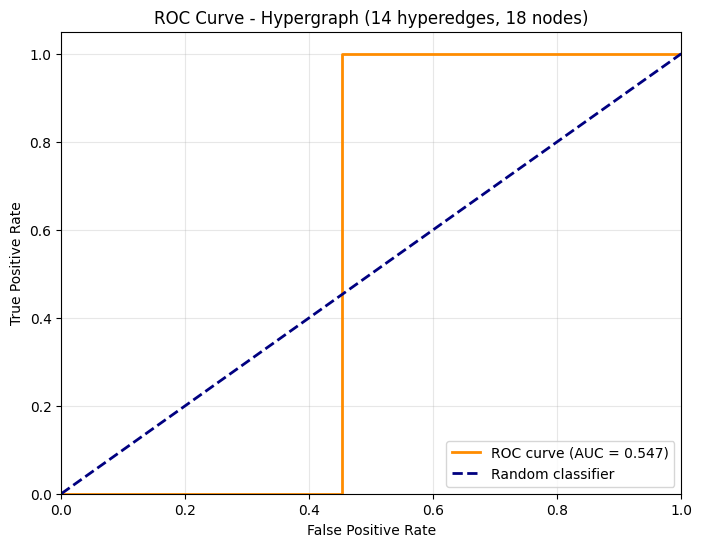

Evaluating structural properties...

WORD EMBEDDINGS ANALYSIS RESULTS (ALL 7 ML SCORES + STRUCTURAL)

Hypergraph Information:
  Number of hyperedges: 14
  Number of nodes: 18
  Average hyperedge size: 9.64

Machine Learning Scores:
  F1 Score: 0.1818
  Recall: 1.0000
  Precision: 0.1000
  Accuracy: 0.5500
  ROC-AUC: 0.5474
  Log Loss: 1.0346
  Matthews Correlation Coefficient: 0.2294

Structural Evaluation Scores:
  Avg. Internal Connectivity (Predicted): 0.6568
  Avg. Internal Connectivity (Random Baseline): 0.6339
  Connectivity Ratio (Predicted/Random): 1.04
  Avg. Node Degree (Overall): 7.50
  Avg. Node Degree (In Predictions): 7.62



In [7]:
# Southern Women Dataset (Davis, Gardner, Gardner, 1941)
southern_women = {
    'E1': {'Evelyn', 'Laura', 'Theresa', 'Brenda', 'Charlotte', 'Frances', 'Eleanor', 'Pearl', 'Ruth', 'Verne', 'Myrna', 'Katherine', 'Sylvia', 'Nora', 'Helen', 'Dorothy', 'Olivia', 'Flora'},
    'E2': {'Evelyn', 'Laura', 'Theresa', 'Brenda', 'Charlotte', 'Frances', 'Eleanor', 'Pearl', 'Ruth', 'Verne', 'Myrna', 'Katherine', 'Sylvia', 'Nora', 'Helen'},
    'E3': {'Evelyn', 'Laura', 'Theresa', 'Brenda', 'Charlotte', 'Frances', 'Eleanor', 'Pearl', 'Ruth', 'Verne', 'Myrna', 'Katherine', 'Sylvia', 'Nora'},
    'E4': {'Evelyn', 'Laura', 'Theresa', 'Brenda', 'Charlotte', 'Frances', 'Eleanor', 'Pearl', 'Ruth', 'Verne', 'Myrna', 'Katherine', 'Sylvia'},
    'E5': {'Evelyn', 'Laura', 'Theresa', 'Brenda', 'Charlotte', 'Frances', 'Eleanor', 'Pearl', 'Ruth', 'Verne', 'Myrna', 'Katherine'},
    'E6': {'Evelyn', 'Laura', 'Theresa', 'Brenda', 'Charlotte', 'Frances', 'Eleanor', 'Pearl', 'Ruth', 'Verne', 'Myrna'},
    'E7': {'Evelyn', 'Laura', 'Theresa', 'Brenda', 'Charlotte', 'Frances', 'Eleanor', 'Pearl', 'Ruth', 'Verne'},
    'E8': {'Evelyn', 'Laura', 'Theresa', 'Brenda', 'Charlotte', 'Frances', 'Eleanor', 'Pearl', 'Ruth'},
    'E9': {'Evelyn', 'Laura', 'Theresa', 'Brenda', 'Charlotte', 'Frances', 'Eleanor', 'Pearl'},
    'E10': {'Evelyn', 'Laura', 'Theresa', 'Brenda', 'Charlotte', 'Frances', 'Eleanor'},
    'E11': {'Evelyn', 'Laura', 'Theresa', 'Brenda', 'Charlotte', 'Frances'},
    'E12': {'Evelyn', 'Laura', 'Theresa', 'Brenda', 'Charlotte'},
    'E13': {'Evelyn', 'Laura', 'Theresa', 'Brenda'},
    'E14': {'Evelyn', 'Laura', 'Theresa'}
}

print("Example 1: Southern Women Hypergraph")
print(f"Number of women (nodes): {len(set().union(*southern_women.values()))}")
print(f"Number of events (hyperedges): {len(southern_women)}")

# Run analysis
results_sw = full_hypergraph_analysis_complete(southern_women, num_predictions=50, random_seed=42, plot_roc=True, embedding_dim=64)
print_results_complete(results_sw)

### Example 2: Karate Club Dataset

Zachary's Karate Club network represented as a hypergraph where cliques form hyperedges.

Example 2: Karate Club Hypergraph
Number of members (nodes): 27
Number of cliques (hyperedges): 10
Starting Word Embeddings Analysis...
Input hypergraph: 10 hyperedges
Incidence matrix shape: (27, 10) (nodes x hyperedges)
Learned 64-dimensional node embeddings
Computed embedding similarity matrix
Average original hyperedge size: 4.70
Generating 50 hyperedge predictions...
Generated 10/50 predictions
Generated 20/50 predictions
Generated 30/50 predictions
Generated 40/50 predictions
Generated 50/50 predictions
Generating classification data for ML evaluation...


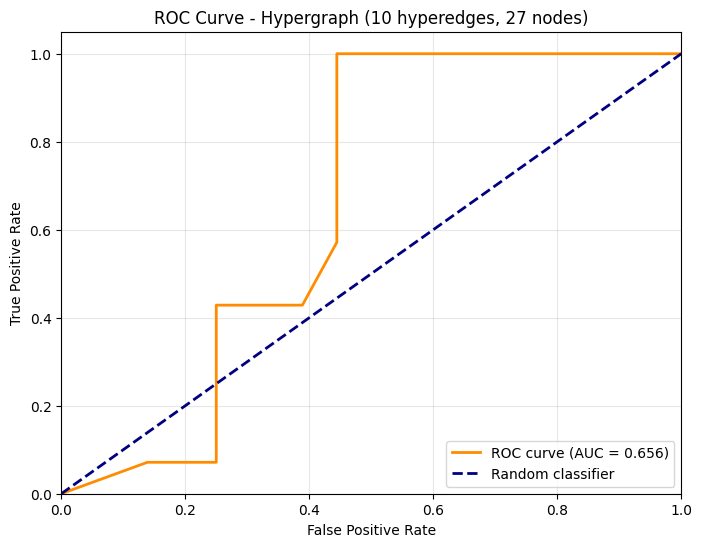

Evaluating structural properties...

WORD EMBEDDINGS ANALYSIS RESULTS (ALL 7 ML SCORES + STRUCTURAL)

Hypergraph Information:
  Number of hyperedges: 10
  Number of nodes: 27
  Average hyperedge size: 4.70

Machine Learning Scores:
  F1 Score: 0.5366
  Recall: 0.7857
  Precision: 0.4074
  Accuracy: 0.6200
  ROC-AUC: 0.6558
  Log Loss: 0.9082
  Matthews Correlation Coefficient: 0.3074

Structural Evaluation Scores:
  Avg. Internal Connectivity (Predicted): 0.7541
  Avg. Internal Connectivity (Random Baseline): 0.1491
  Connectivity Ratio (Predicted/Random): 5.06
  Avg. Node Degree (Overall): 1.74
  Avg. Node Degree (In Predictions): 1.83



In [8]:
# Karate Club Dataset (Zachary, 1977)
karate_club = {
    'clique_1': {1, 2, 3, 4},
    'clique_2': {1, 2, 3, 8},
    'clique_3': {1, 2, 4, 8},
    'clique_4': {2, 3, 4, 14},
    'clique_5': {9, 10, 15, 16, 19, 21},
    'clique_6': {9, 10, 15, 16, 19, 23},
    'clique_7': {25, 26, 28, 29, 32},
    'clique_8': {25, 26, 28, 29, 34},
    'clique_9': {30, 31, 33, 34},
    'clique_10': {5, 6, 7, 11, 17}
}

print("Example 2: Karate Club Hypergraph")
print(f"Number of members (nodes): {len(set().union(*karate_club.values()))}")
print(f"Number of cliques (hyperedges): {len(karate_club)}")

# Run analysis
results_karate = full_hypergraph_analysis_complete(karate_club, num_predictions=50, random_seed=42, plot_roc=True, embedding_dim=64)
print_results_complete(results_karate)

### Example 3: Les Miserables Dataset

Character co-appearance network from Victor Hugo's Les Miserables represented as a hypergraph.

Example 3: Les Miserables Hypergraph
Number of characters (nodes): 11
Number of scenes (hyperedges): 8
Starting Word Embeddings Analysis...
Input hypergraph: 8 hyperedges
Incidence matrix shape: (11, 8) (nodes x hyperedges)
Learned 64-dimensional node embeddings
Computed embedding similarity matrix
Average original hyperedge size: 4.12
Generating 50 hyperedge predictions...
Generated 10/50 predictions
Generated 20/50 predictions
Generated 30/50 predictions
Generated 40/50 predictions
Generated 50/50 predictions
Generating classification data for ML evaluation...


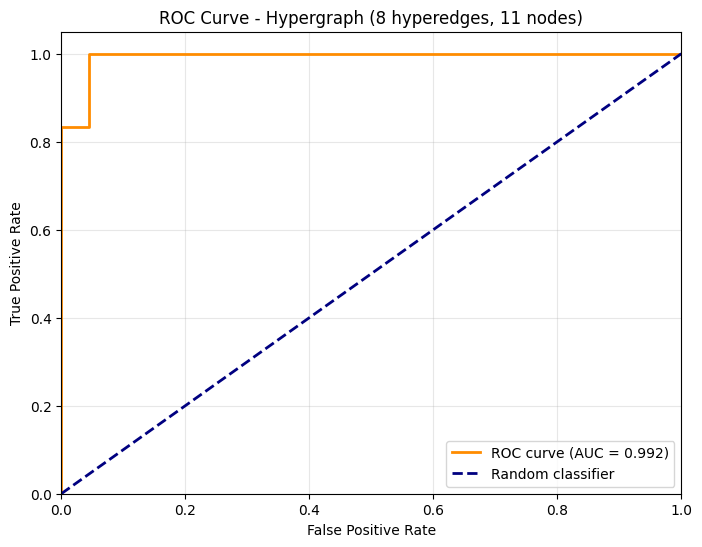

Evaluating structural properties...

WORD EMBEDDINGS ANALYSIS RESULTS (ALL 7 ML SCORES + STRUCTURAL)

Hypergraph Information:
  Number of hyperedges: 8
  Number of nodes: 11
  Average hyperedge size: 4.12

Machine Learning Scores:
  F1 Score: 0.3871
  Recall: 1.0000
  Precision: 0.2400
  Accuracy: 0.6200
  ROC-AUC: 0.9924
  Log Loss: 0.8741
  Matthews Correlation Coefficient: 0.3693

Structural Evaluation Scores:
  Avg. Internal Connectivity (Predicted): 0.4721
  Avg. Internal Connectivity (Random Baseline): 0.2966
  Connectivity Ratio (Predicted/Random): 1.59
  Avg. Node Degree (Overall): 3.00
  Avg. Node Degree (In Predictions): 3.20



In [9]:
# Les Miserables Dataset (Knuth, 1993)
les_miserables = {
    'scene_1': {'Valjean', 'Javert', 'Fantine', 'Cosette'},
    'scene_2': {'Valjean', 'Cosette', 'Marius', 'Eponine'},
    'scene_3': {'Marius', 'Eponine', 'Gavroche', 'Enjolras'},
    'scene_4': {'Enjolras', 'Combeferre', 'Courfeyrac', 'Gavroche'},
    'scene_5': {'Thenardier', 'Eponine', 'Gavroche', 'Cosette'},
    'scene_6': {'Valjean', 'Javert', 'Marius', 'Cosette'},
    'scene_7': {'Fantine', 'Cosette', 'Valjean', 'Javert'},
    'scene_8': {'Enjolras', 'Marius', 'Courfeyrac', 'Gavroche', 'Valjean'}
}

print("Example 3: Les Miserables Hypergraph")
print(f"Number of characters (nodes): {len(set().union(*les_miserables.values()))}")
print(f"Number of scenes (hyperedges): {len(les_miserables)}")

# Run analysis
results_lesmiserables = full_hypergraph_analysis_complete(les_miserables, num_predictions=50, random_seed=42, plot_roc=True, embedding_dim=64)
print_results_complete(results_lesmiserables)

### Example 4: Random Hypergraph

A randomly generated hypergraph for testing the algorithm on synthetic data.

Example 4: Random Hypergraph
Number of nodes: 19
Number of hyperedges: 12
Starting Word Embeddings Analysis...
Input hypergraph: 12 hyperedges
Incidence matrix shape: (19, 12) (nodes x hyperedges)
Learned 64-dimensional node embeddings
Computed embedding similarity matrix
Average original hyperedge size: 3.83
Generating 50 hyperedge predictions...
Generated 10/50 predictions
Generated 20/50 predictions
Generated 30/50 predictions
Generated 40/50 predictions
Generated 50/50 predictions
Generating classification data for ML evaluation...


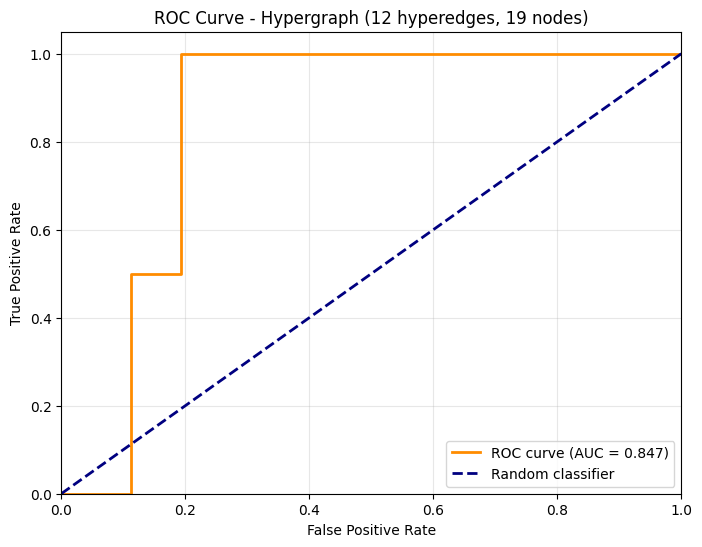

Evaluating structural properties...

WORD EMBEDDINGS ANALYSIS RESULTS (ALL 7 ML SCORES + STRUCTURAL)

Hypergraph Information:
  Number of hyperedges: 12
  Number of nodes: 19
  Average hyperedge size: 3.83

Machine Learning Scores:
  F1 Score: 0.0769
  Recall: 1.0000
  Precision: 0.0400
  Accuracy: 0.5200
  ROC-AUC: 0.8469
  Log Loss: 0.8338
  Matthews Correlation Coefficient: 0.1429

Structural Evaluation Scores:
  Avg. Internal Connectivity (Predicted): 0.3834
  Avg. Internal Connectivity (Random Baseline): 0.1723
  Connectivity Ratio (Predicted/Random): 2.22
  Avg. Node Degree (Overall): 2.42
  Avg. Node Degree (In Predictions): 2.55



In [10]:
# Random Hypergraph
vertices = list(range(1, 21))  # 20 vertices
hyperedge_names = [f'he_{i}' for i in range(1, 16)]  # 15 hyperedge names

random_hypergraph = hypergraph_random_creator(
    vertices=vertices,
    hyperedge_names=hyperedge_names,
    m=12,  # 12 hyperedges
    minv=2,  # minimum 2 nodes per hyperedge
    maxv=6,  # maximum 6 nodes per hyperedge
    weighted=False
)

print("Example 4: Random Hypergraph")
print(f"Number of nodes: {len(set().union(*random_hypergraph.values()))}")
print(f"Number of hyperedges: {len(random_hypergraph)}")

# Run analysis
results_random = full_hypergraph_analysis_complete(random_hypergraph, num_predictions=50, random_seed=42, plot_roc=True, embedding_dim=64)
print_results_complete(results_random)

## Comparison Tables

In [12]:
def create_complete_comparison_table_with_save(results_list, example_names, 
                                               method_name, task_name, 
                                               save_dir="results", 
                                               display_results=True):
    
    comparison_data = []
    
    for i, results in enumerate(results_list):
        hg_info = results['hypergraph_info']
        ml_scores = results['ml_scores']
        eval_scores = results['structural_evaluation']
        
        row = {
            'Hypergraph': example_names[i],
            'Nodes': hg_info['num_nodes'],
            'Hyperedges': hg_info['num_hyperedges'],
            'Avg HE Size': round(hg_info['avg_hyperedge_size'], 2),
            # The 7 ML Scores
            'F1 Score': round(ml_scores['f1'], 4),
            'Recall': round(ml_scores['recall'], 4),
            'Precision': round(ml_scores['precision'], 4),
            'Accuracy': round(ml_scores['accuracy'], 4),
            'ROC-AUC': round(ml_scores['roc_auc'], 4),
            'Log Loss': round(ml_scores['log_loss'], 4) if ml_scores['log_loss'] != float('inf') else 'inf',
            'Matthews Coeff': round(ml_scores['matthews_corrcoef'], 4),
            # Structural Scores
            'Predicted Connectivity': round(eval_scores['avg_predicted_internal_connectivity'], 4),
            'Random Connectivity': round(eval_scores['avg_random_baseline_connectivity'], 4),
            'Connectivity Ratio': round(eval_scores['connectivity_ratio'], 2),
            'Avg Node Degree (Overall)': round(eval_scores['avg_overall_node_degree'], 2),
            'Avg Node Degree (Predicted)': round(eval_scores['avg_node_degree_in_predictions'], 2)
        }
        comparison_data.append(row)
    
    # Create DataFrame
    df = pd.DataFrame(comparison_data)
    
    # Save results for aggregation
    save_results_for_aggregation(df, method_name, task_name, save_dir)
    
    # Display results if requested (original functionality)
    if display_results:
        display_comparison_tables(df)
    
    return df

def save_results_for_aggregation(df, method_name, task_name, save_dir):
    """
    Save the comparison results in a structured format for later aggregation.
    """
    # Create directory structure
    method_dir = Path(save_dir) / method_name
    method_dir.mkdir(parents=True, exist_ok=True)
    
    # Prepare data for saving
    save_data = {
        'metadata': {
            'method': method_name,
            'task': task_name,
            'timestamp': datetime.now().isoformat(),
            'num_hypergraphs': len(df)
        },
        'results': df.to_dict('records')
    }
    
    # Save to JSON file
    filename = f"{task_name}_results.json"
    filepath = method_dir / filename
    
    with open(filepath, 'w') as f:
        json.dump(save_data, f, indent=2, default=str)
    
    print(f"✓ Results saved to: {filepath}")

def display_comparison_tables(df):
    """
    Display the comparison tables in the original format.
    """
    # Set pandas display options for better formatting
    pd.set_option('display.max_columns', None)
    pd.set_option('display.precision', 4)

    # 1. ML SCORES COMPARISON TABLE (FIRST)
    print("\n" + "="*90)
    print("ML SCORES COMPARISON TABLE")
    print("="*90)
    ml_columns = ['Hypergraph', 'F1 Score', 'Recall', 'Precision', 'Accuracy', 'ROC-AUC', 'Log Loss', 'Matthews Coeff']
    ml_df = df[ml_columns]

    # Format ML table nicely
    print(f"{'Hypergraph':<20} {'F1':<8} {'Recall':<8} {'Precision':<10} {'Accuracy':<9} {'ROC-AUC':<8} {'Log Loss':<9} {'Matthews':<9}")
    print("-" * 90)
    for i, row in ml_df.iterrows():
        # Handle potential string values (like 'inf')
        log_loss_str = f"{row['Log Loss']:.4f}" if isinstance(row['Log Loss'], (int, float)) else str(row['Log Loss'])
        print(f"{row['Hypergraph']:<20} {row['F1 Score']:<8.4f} {row['Recall']:<8.4f} {row['Precision']:<10.4f} {row['Accuracy']:<9.4f} {row['ROC-AUC']:<8.4f} {log_loss_str:<9} {row['Matthews Coeff']:<9.4f}")
    print("="*90)

    # 2. STRUCTURAL SCORES COMPARISON TABLE
    print("\n\n" + "="*100)
    print("STRUCTURAL SCORES COMPARISON TABLE")
    print("="*100)

    structural_columns = ['Hypergraph', 'Nodes', 'Hyperedges', 'Avg HE Size', 'Predicted Connectivity', 
                         'Random Connectivity', 'Connectivity Ratio']
    structural_df = df[structural_columns]

    # Format structural table nicely
    print(f"{'Hypergraph':<20} {'Nodes':<6} {'HEdges':<7} {'Avg Size':<9} {'Pred Conn':<10} {'Rand Conn':<10} {'Conn Ratio':<10}")
    print("-" * 100)
    for i, row in structural_df.iterrows():
        print(f"{row['Hypergraph']:<20} {row['Nodes']:<6} {row['Hyperedges']:<7} {row['Avg HE Size']:<9.2f} {row['Predicted Connectivity']:<10.4f} {row['Random Connectivity']:<10.4f} {row['Connectivity Ratio']:<10.2f}")
    print("="*100)

    # 3. COMPLETE COMPARISON TABLE (SIMPLIFIED)
    print("\n\n" + "="*80)
    print("COMPLETE COMPARISON TABLE - SUMMARY")
    print("="*80)
    print("(Showing key metrics only for readability)")
    print("-"*80)
    summary_columns = ['Hypergraph', 'Nodes', 'Hyperedges', 'F1 Score', 'ROC-AUC', 'Connectivity Ratio']
    summary_df = df[summary_columns]
    print(f"{'Hypergraph':<20} {'Nodes':<6} {'HEdges':<8} {'F1':<8} {'ROC-AUC':<8} {'Conn Ratio':<11}")
    print("-" * 80)
    for i, row in summary_df.iterrows():
        print(f"{row['Hypergraph']:<20} {row['Nodes']:<6} {row['Hyperedges']:<8} {row['F1 Score']:<8.4f} {row['ROC-AUC']:<8.4f} {row['Connectivity Ratio']:<11.2f}")
    print("="*80)

example_names = ['Southern Women', 'Karate Club', 'Les Miserables', 'Random Hypergraph']
results_list = [results_sw, results_karate, results_lesmiserables, results_random]

comparison_df = create_complete_comparison_table_with_save(
    results_list=results_list,
    example_names=example_names,
    method_name='Word_Embeddings',
    task_name='hypergraph_reconstruction',
    save_dir='results',
    display_results=True
)    

✓ Results saved to: results/Word_Embeddings/hypergraph_reconstruction_results.json

ML SCORES COMPARISON TABLE
Hypergraph           F1       Recall   Precision  Accuracy  ROC-AUC  Log Loss  Matthews 
------------------------------------------------------------------------------------------
Southern Women       0.1818   1.0000   0.1000     0.5500    0.5474   1.0346    0.2294   
Karate Club          0.5366   0.7857   0.4074     0.6200    0.6558   0.9082    0.3074   
Les Miserables       0.3871   1.0000   0.2400     0.6200    0.9924   0.8741    0.3693   
Random Hypergraph    0.0769   1.0000   0.0400     0.5200    0.8469   0.8338    0.1429   


STRUCTURAL SCORES COMPARISON TABLE
Hypergraph           Nodes  HEdges  Avg Size  Pred Conn  Rand Conn  Conn Ratio
----------------------------------------------------------------------------------------------------
Southern Women       18     14      9.64      0.6568     0.6339     1.04      
Karate Club          27     10      4.70      0.7541     